# DSI Team Starting Point

### Background

DSI Phase I:
- Cleaned and Analyzed Historical CFPB Agreement Data looking to understand offered APRs
    - Team found initial analysis lacking in meaning due to the nature of the APR values reported in the agreements
        - The Reported APRs were listed as a "middle point" across customer segments per plan per agreement.
        - This ultiamtely meant that the APR value was already a range or a value from a range rather than the discreet values themselves.
    - Later found out from data stewards that the historical data is non-verifiable, meaning the reported APRs were hard to relate to the actual offerings at that time.
    - Data Teams Presentations:
        - <a href="https://github.com/chrisJoyceDS/top_sprint_data/blob/main/code/CFPB_Data.ipynb"> Jupyter Notebook Repo </a>
        - <a href="https://docs.google.com/presentation/d/16vBsI7b5Fw_0tF1UQK4qW2dn32v66PwcC3VZ959mx4c/edit#slide=id.p"> Presentation to the Team </a>
        - <a href="https://docs.google.com/presentation/d/18uy5qkw0zQTg-SA-ceXDKOI2dCI4RLN-IjSQXfIwCIM/edit#slide=id.p"> Presentation to the CFPB </a>

DSI Phase II:
- After having it confirmed that the historical data was innacurate and far from reality, the team learned of and used the updated dataset provided by the CFPB
- This data was from July 2022 to December 2022 and had a variety of updated information with respect to the historical data
- Unfortunately there is no data dictionary for this dataset, and we will have to interpet their values based on the column descriptions
- for the sake of the team, we left most of the column names intact, and update a few where we thought it was best/relevant
- Please follow us along or Select "Jump to Clustering" below:

[Jump to Clustering](#Clustering)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import cm
import seaborn as sns
import re
import missingno as msno

# imputing
from sklearn.impute import KNNImputer
# preprocessing
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import make_column_transformer
#clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

- The dataset data doesn't fall on the usual A0 cell, we needed to adjust the pandas reader

In [296]:
columns_to_read = 'B:FO'

In [297]:
df = pd.read_excel("../data/cfpb_updated_tccp.xlsx",skiprows=9,usecols=columns_to_read)

In [298]:
df.head()

,Institution Name,Product Name,Report Date,Availability of Credit Card Plan,State,State (Multiple),Pertains to Specific Counties?,Requirements for Opening,Requirements for Opening Types,Geographic Restrictions,...,Services,Other Services,Rewards,Other Rewards,Card Features,Other Card Features,Contact Information Types,Website for Consumer,Telephone Number for Consumers,Created Date
0,FNBT BANK,MasterCard,Data as of December 31,National,NaN,NaN,NaN,No,NaN,NaN,...,NaN,NaN,Cashback rewards,NaN,Chip card,NaN,Phone; Website,https:www.fnbt.com,1-800-899-4321,3/21/2023
1,WINTHROP AREA FEDERAL CREDIT UNION,Visa Credit Platinum,Data as of December 31,National,NaN,NaN,NaN,No,NaN,NaN,...,NaN,NaN,Cashback rewards; Travel-related rewards,NaN,Contactless Payments; Chip card; Fee-free fore...,NaN,Phone; Website,https://www.winthropcreditunion.org,800-511-1120,3/21/2023
2,WOORI AMERICA BANK,Classic,Data as of December 31,National,NaN,NaN,NaN,Yes,NaN,NaN,...,Automobile rental insurance; Credit card regis...,NaN,Travel-related rewards,NaN,Chip card; Fee-free foreign transactions; Mobi...,NaN,Website,https://www.wooriamericabank.com,NaN,3/21/2023
3,CENTRAL BANK & TRUST COMPANY,Classic Visa,Data as of December 31,Regional,NaN,IN; KY; OH,No,Yes,NaN,NaN,...,Automobile rental insurance; Other,Roadside assistance,NaN,NaN,Contactless Payments; Chip card; Mobile wallet...,NaN,Phone; Website,https://www.centralbank.com,(800)637-6884,3/22/2023
4,CLEARWATER FEDERAL CREDIT UNION,Visa,Data as of December 31,National,NaN,NaN,NaN,No,Other. Please Describe:,NaN,...,Debt cancellation coverage; Other,Visa's credit monitoring (Norton Lifelock cred...,NaN,NaN,Contactless Payments; Chip card; Mobile wallet...,NaN,Phone; Website,https://www.clearwatercreditunion.org,800-254-1803,3/22/2023


In [299]:
df.shape

(648, 170)

- Key differences between this data set and the historical data set
    - This is not timeseries, it is each institution's plan data as of December 31 of the participants in the survey
    - Phase I dataset was (rows:9556,columns:12)
    - more dense of a dataset
- let's check out the null landscape below

<Axes: >

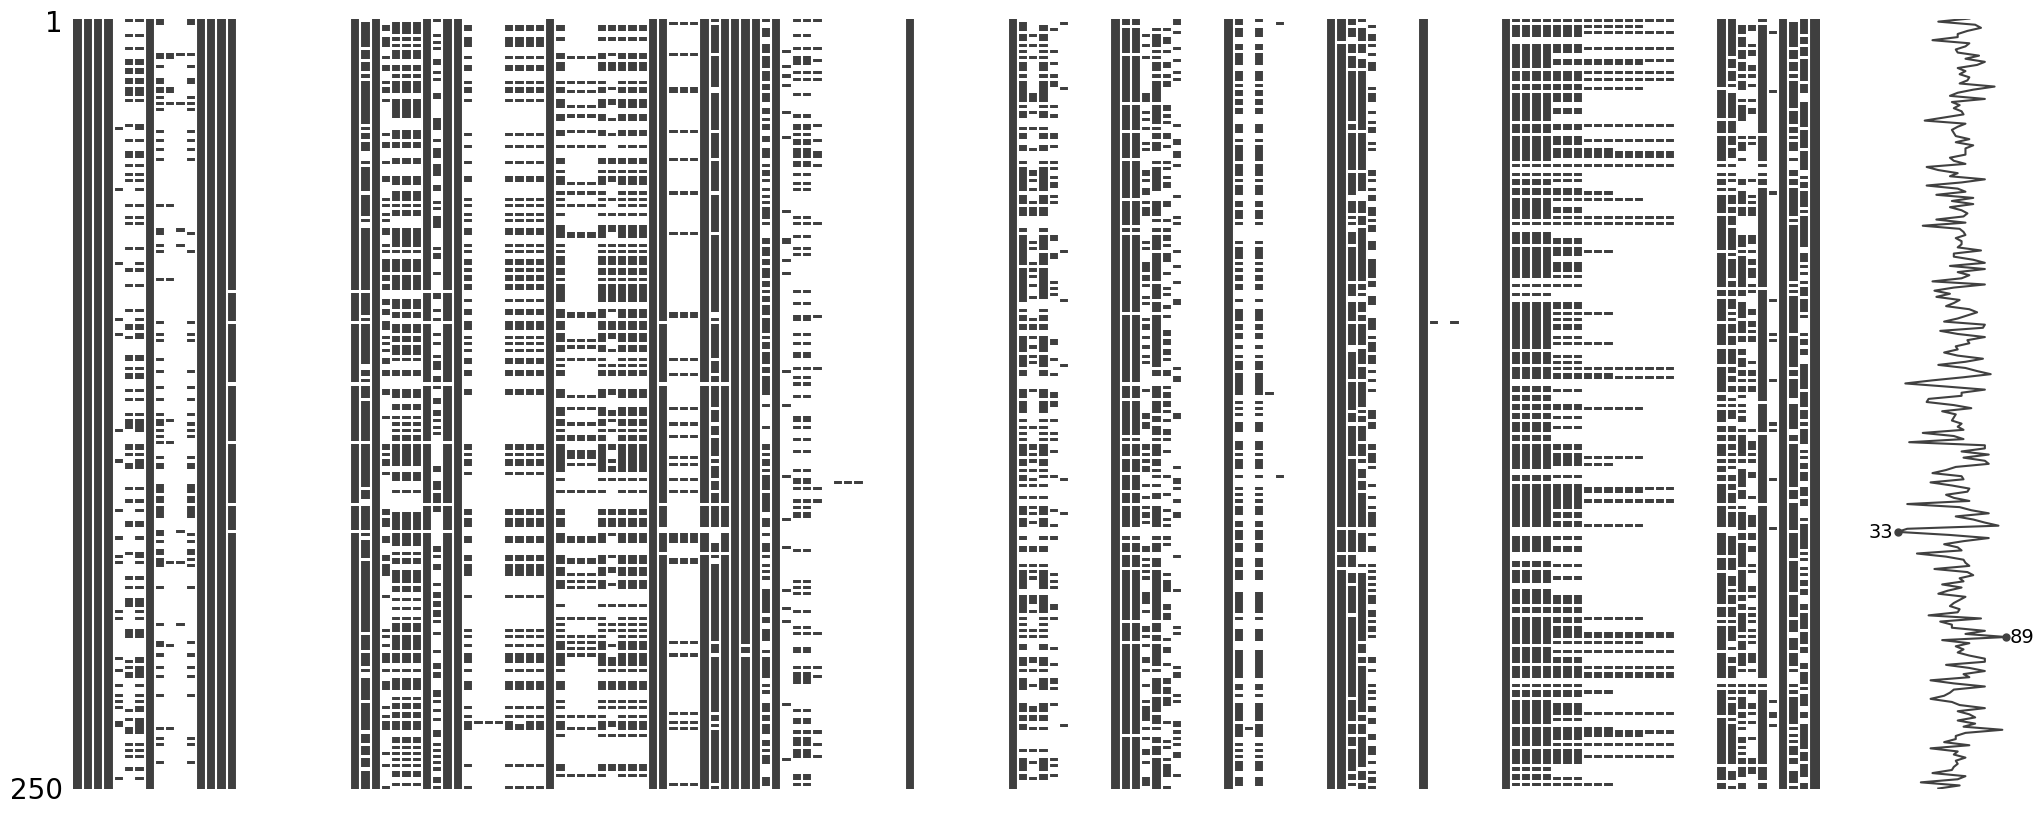

In [300]:
msno.matrix(df.sample(250))

- What you are seeing is a graphical representation of the data within the new data set:
    - Black means data
    - White means no data
- With more fields collected, comes the even possibility of not collecting it.
- Below is the start of our initial clean process. Because of the look of the dataset above, and the sheer amount of initial features we have (170) we are going to make some swift cuts

In [301]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 648 entries, 0 to 647
Columns: 170 entries, Institution Name to Created Date
dtypes: float64(97), object(73)
memory usage: 860.8+ KB


In [302]:
# Calculate the percentage of null values in each column
null_percentage = (df.isnull().sum() / len(df)) * 100

In [303]:
type(null_percentage)

pandas.core.series.Series

In [304]:
null_percentage.shape

(170,)

In [305]:
# set threshold
threshold = 90

In [306]:
# Create a list of column names to drop where the null percentage is greater than or equal to the threshold
columns_to_drop = null_percentage[null_percentage >= threshold].index.tolist()

In [307]:
len(columns_to_drop)

68

In [308]:
# drop the columns
df.drop(columns=columns_to_drop,inplace=True)

In [309]:
df.shape

(648, 102)

- Above we:
    - Calculated the null percentage for each column of the 170
    - set a threshold of 90 percent null as the cut off
    - removed all columns that met that threshould and above
    - resulting in dropping 68 columns
- You can see the impact below, and it's much better, but we still have 102 features, which means we will be greedier in our selection

<Axes: >

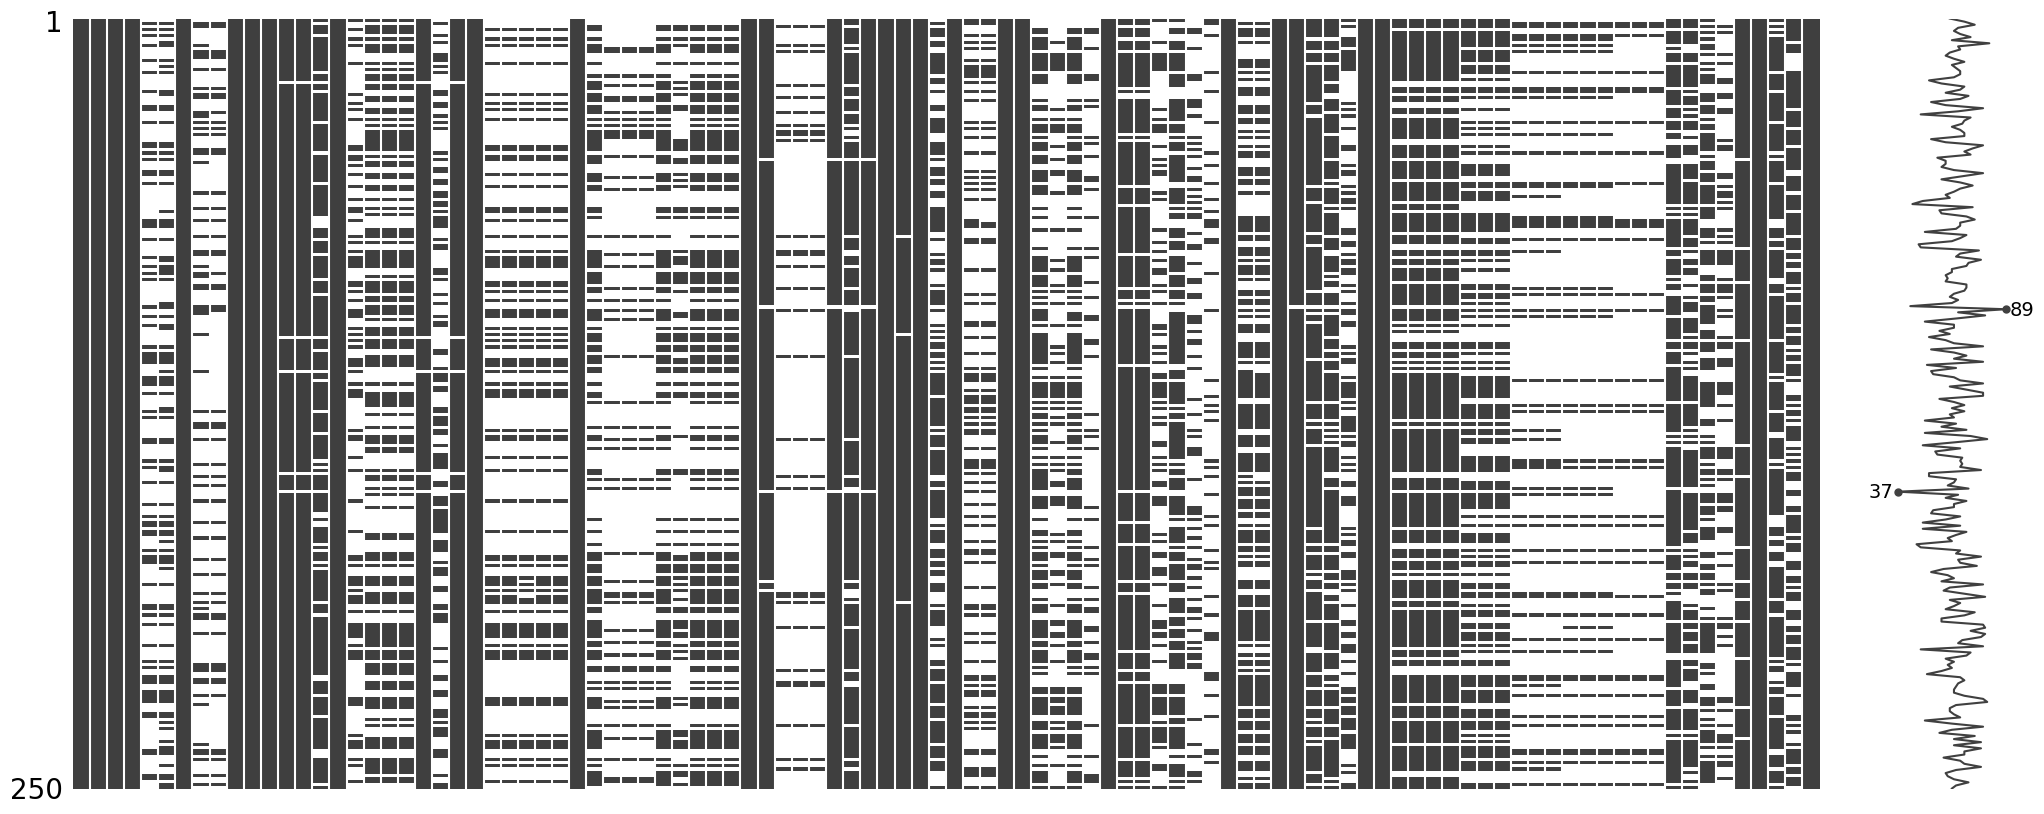

In [310]:
msno.matrix(df.sample(250))

In [311]:
df.head()

,Institution Name,Product Name,Report Date,Availability of Credit Card Plan,State (Multiple),Pertains to Specific Counties?,Requirements for Opening,Requirements for Opening Types,Other,Secured Card,...,Other Fee Explanation.4,Services,Other Services,Rewards,Other Rewards,Card Features,Contact Information Types,Website for Consumer,Telephone Number for Consumers,Created Date
0,FNBT BANK,MasterCard,Data as of December 31,National,NaN,NaN,No,NaN,NaN,No,...,NaN,NaN,NaN,Cashback rewards,NaN,Chip card,Phone; Website,https:www.fnbt.com,1-800-899-4321,3/21/2023
1,WINTHROP AREA FEDERAL CREDIT UNION,Visa Credit Platinum,Data as of December 31,National,NaN,NaN,No,NaN,NaN,No,...,NaN,NaN,NaN,Cashback rewards; Travel-related rewards,NaN,Contactless Payments; Chip card; Fee-free fore...,Phone; Website,https://www.winthropcreditunion.org,800-511-1120,3/21/2023
2,WOORI AMERICA BANK,Classic,Data as of December 31,National,NaN,NaN,Yes,NaN,NaN,No,...,NaN,Automobile rental insurance; Credit card regis...,NaN,Travel-related rewards,NaN,Chip card; Fee-free foreign transactions; Mobi...,Website,https://www.wooriamericabank.com,NaN,3/21/2023
3,CENTRAL BANK & TRUST COMPANY,Classic Visa,Data as of December 31,Regional,IN; KY; OH,No,Yes,NaN,NaN,No,...,NaN,Automobile rental insurance; Other,Roadside assistance,NaN,NaN,Contactless Payments; Chip card; Mobile wallet...,Phone; Website,https://www.centralbank.com,(800)637-6884,3/22/2023
4,CLEARWATER FEDERAL CREDIT UNION,Visa,Data as of December 31,National,NaN,NaN,No,Other. Please Describe:,Person must qualify for membership based on th...,No,...,NaN,Debt cancellation coverage; Other,Visa's credit monitoring (Norton Lifelock cred...,NaN,NaN,Contactless Payments; Chip card; Mobile wallet...,Phone; Website,https://www.clearwatercreditunion.org,800-254-1803,3/22/2023


In [312]:
# get remaining column data types
col_types = df.dtypes

In [313]:
# separate out numerical and object columns
num_cols = col_types[col_types != 'object'].index.tolist()
obj_cols = col_types[col_types == 'object'].index.tolist()

In [314]:
df[num_cols].shape

(648, 40)

In [315]:
df[obj_cols].shape

(648, 62)

In [316]:
df[num_cols].isnull().sum().sum(), df[obj_cols].isnull().sum().sum()

(13313, 11087)

In [317]:
# re-Calculate the percentage of null values in each column
null_percentage = (df.isnull().sum() / len(df)) * 100

In [318]:
null_percentage.sort_values(ascending=False)[null_percentage >= 59]

Good Credit.3                           89.197531
Great Credit.3                          89.197531
Poor or Fair Credit.3                   89.197531
Other Fee Explanation.4                 88.425926
Other Fee Name.4                        88.425926
Other Fee Amount.4                      88.425926
Other Fee Name.3                        83.796296
Poor or Fair Credit.2                   83.796296
Other Fee Amount.3                      83.796296
Other Fee Explanation.3                 83.796296
Good Credit.2                           83.796296
Great Credit.2                          83.796296
Cash Advance Fee Calculation            81.481481
Other Fee Amount.2                      81.481481
Other Fee Explanation.2                 81.481481
Other Fee Name.2                        81.481481
Other                                   80.555556
Minimum Balance Transfer Fee Amount     80.401235
Requirements for Opening Types          75.000000
Minimum Cash Advance Fee Amount         68.827160


In [319]:
# additional columns to drop
cols_to_drop = null_percentage[null_percentage >= 60].index.tolist()

In [320]:
len(cols_to_drop)

34

In [321]:
# drop additional columns
# drop the columns
df.drop(columns=cols_to_drop,inplace=True)

In [322]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 648 entries, 0 to 647
Data columns (total 68 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Institution Name                          648 non-null    object 
 1   Product Name                              648 non-null    object 
 2   Report Date                               648 non-null    object 
 3   Availability of Credit Card Plan          648 non-null    object 
 4   Requirements for Opening                  648 non-null    object 
 5   Secured Card                              648 non-null    object 
 6   Targeted Credit Tiers                     648 non-null    object 
 7   Purchase APR Offered?                     648 non-null    object 
 8   Purchase APR Vary by Balance              634 non-null    object 
 9   Purchase APR Index                        634 non-null    object 
 10  Variable Rate Index                   

- Same exercise, new threshold, this time anything that was greater or equal to 59% null
- Now we have 68 Columns (5.5 times the features we had with historical btw) with a much better look of data below

<Axes: >

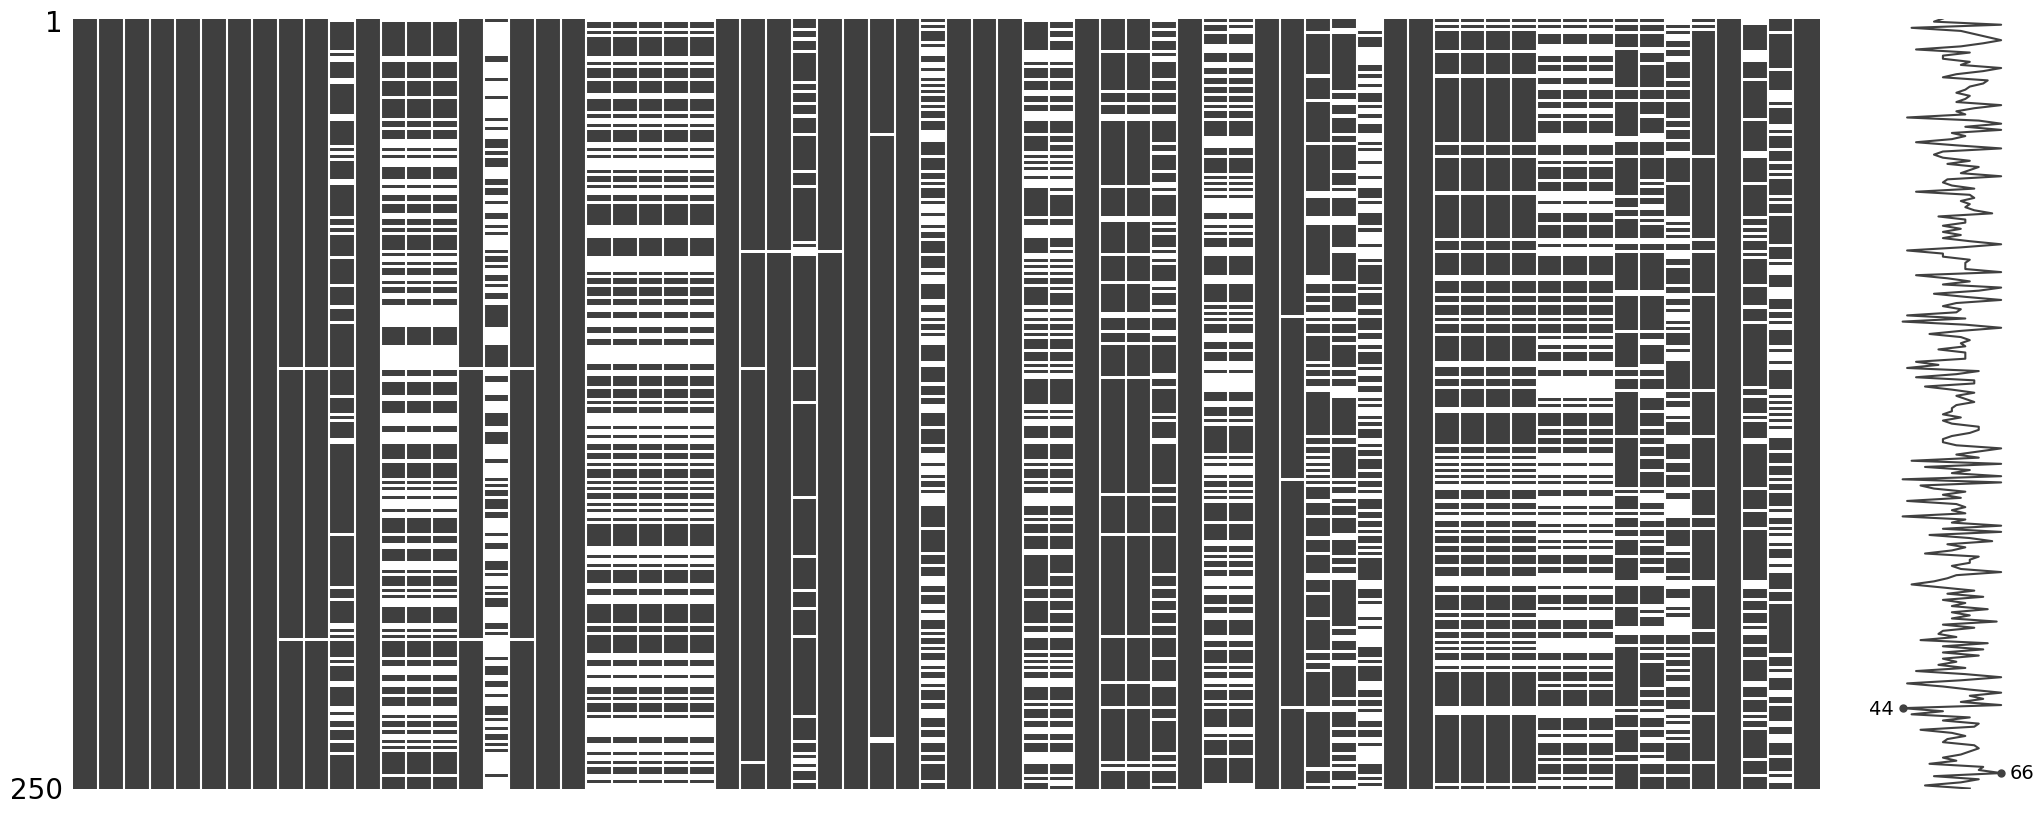

In [323]:
msno.matrix(df.sample(250))

In [324]:
df.columns.shape

(68,)

- Something you will have noticed, if you read our initial analysis, is that there are less visualizations for this data set
- There will be more going forward, but for now we have prioritized creating aggregate cards for the Software Engineering Team to be able to start building
- From this point we will be doing a mix of cleaning, feature engineering, preprocessing, and clustering

---
## MVP Goal

- Create Aggregate cards based on the targeted credit tiers 
- Capture APR, Grace Periods, Late Fees, Rewards, and Annual Fees

### Columns 0 - 10 Clean & FE
---

In [325]:
df.iloc[:5, 0:11]

,Institution Name,Product Name,Report Date,Availability of Credit Card Plan,Requirements for Opening,Secured Card,Targeted Credit Tiers,Purchase APR Offered?,Purchase APR Vary by Balance,Purchase APR Index,Variable Rate Index
0,FNBT BANK,MasterCard,Data as of December 31,National,No,No,Good credit (credit scores from 620 to 719),Yes,No,No,NaN
1,WINTHROP AREA FEDERAL CREDIT UNION,Visa Credit Platinum,Data as of December 31,National,No,No,Good credit (credit scores from 620 to 719); G...,Yes,No,No,NaN
2,WOORI AMERICA BANK,Classic,Data as of December 31,National,Yes,No,Good credit (credit scores from 620 to 719); G...,Yes,No,Yes,Prime
3,CENTRAL BANK & TRUST COMPANY,Classic Visa,Data as of December 31,Regional,Yes,No,Poor or fair credit (credit score 619 or less)...,No,NaN,NaN,NaN
4,CLEARWATER FEDERAL CREDIT UNION,Visa,Data as of December 31,National,No,No,Poor or fair credit (credit score 619 or less)...,Yes,No,No,NaN


- null count of these first 10 columns

In [326]:
df.iloc[:, 0:11].isnull().sum()

Institution Name                      0
Product Name                          0
Report Date                           0
Availability of Credit Card Plan      0
Requirements for Opening              0
Secured Card                          0
Targeted Credit Tiers                 0
Purchase APR Offered?                 0
Purchase APR Vary by Balance         14
Purchase APR Index                   14
Variable Rate Index                 113
dtype: int64

- Here we are seeing if the count of rows when the column "Purchase APR Offered?" is no, equals the amount of null values in the subsequent Purchase qeustions
- it does in fact match and we can assume these values are missing because the parent question was False, in order to clean we will impute with our made up variable of '__'

In [327]:
df[df["Purchase APR Offered?"] == "No"].count()

Institution Name                    14
Product Name                        14
Report Date                         14
Availability of Credit Card Plan    14
Requirements for Opening            14
                                    ..
Card Features                       13
Contact Information Types           14
Website for Consumer                11
Telephone Number for Consumers      13
Created Date                        14
Length: 68, dtype: int64

In [328]:
# 14 null values exist in this column, which matches up with when Purchase APR Offered? is No. For eventual encoding, we are preserving the relationship by replacing null values with __
df["Purchase APR Vary by Balance"].fillna('__', inplace=True)

In [329]:
# 14 null values exist in this column, which matches up with when Purchase APR Offered? is No. For eventual encoding, we are preserving the relationship by replacing null values with __
df["Purchase APR Index"].fillna('__', inplace=True)

In [330]:
mask = df["Variable Rate Index"].isna()

In [331]:
select_cols = ["Purchase APR Offered?","Purchase APR Vary by Balance","Purchase APR Index","Variable Rate Index"]

In [332]:
for col in df[mask][select_cols]:
    print(df[mask][col].value_counts())

Yes    99
No     14
Name: Purchase APR Offered?, dtype: int64
No    99
__    14
Name: Purchase APR Vary by Balance, dtype: int64
No    99
__    14
Name: Purchase APR Index, dtype: int64
Series([], Name: Variable Rate Index, dtype: int64)


In [333]:
# 113 null values, all related to either No values in related columns or our own input for NaN Values, similar decision in preserving relationship by replacing with __
df["Variable Rate Index"].fillna('__', inplace=True)

- Here we try some feature engineering to translate the "Targeted Credit Tiers" column into 3 binary columns denoting whether a given credit card plan belongs to one or many

In [334]:
df["Targeted Credit Tiers"].value_counts()

Poor or fair credit (credit score 619 or less); Good credit (credit scores from 620 to 719); Great Credit (credit score of 720 or greater)    275
Good credit (credit scores from 620 to 719); Great Credit (credit score of 720 or greater)                                                    164
Great Credit (credit score of 720 or greater)                                                                                                  89
Poor or fair credit (credit score 619 or less)                                                                                                 80
Good credit (credit scores from 620 to 719)                                                                                                    34
Poor or fair credit (credit score 619 or less); Good credit (credit scores from 620 to 719)                                                     6
Name: Targeted Credit Tiers, dtype: int64

- this is me being cautions and saving a checkpoint csv

In [335]:
df_clean_copy = df.copy()

In [336]:
df_clean_copy.to_csv("../data/aggregated_cars_preclean.csv")

In [350]:
df = pd.read_csv("../data/aggregated_cars_preclean.csv", index_col=0)

- lowercase the answers

In [351]:
df["Targeted Credit Tiers"] = df["Targeted Credit Tiers"].apply(lambda x: x.lower())

- check the different answer combinations of the data

In [352]:
df["Targeted Credit Tiers"].value_counts()

poor or fair credit (credit score 619 or less); good credit (credit scores from 620 to 719); great credit (credit score of 720 or greater)    275
good credit (credit scores from 620 to 719); great credit (credit score of 720 or greater)                                                    164
great credit (credit score of 720 or greater)                                                                                                  89
poor or fair credit (credit score 619 or less)                                                                                                 80
good credit (credit scores from 620 to 719)                                                                                                    34
poor or fair credit (credit score 619 or less); good credit (credit scores from 620 to 719)                                                     6
Name: Targeted Credit Tiers, dtype: int64

- split the strings on the ';'
- for the non technical this just makes it easier for us to interact with
- Goes from:
    - good credit (credit scores from 620 to 719); great credit (credit score of 720 or greater) 
    - to
    - ['good credit (credit scores from 620 to 719)',
 'great credit (credit score of 720 or greater)']

In [353]:
df["Targeted Credit Tiers"] = df["Targeted Credit Tiers"].str.split("; ")

- Create three columns that align with the credit score group.
- if the word is found in a given list of options for a specific group, report True, else False 

In [355]:
# Create Separate Columns for each bucket
df['Poor_Fair_Group'] = df['Targeted Credit Tiers'].apply(lambda x: any(re.search(r'poor', s) for s in x))
df['Good_Credit_Group'] = df['Targeted Credit Tiers'].apply(lambda x: any(re.search(r'good', s) for s in x))
df['Great_Credit_Group'] = df['Targeted Credit Tiers'].apply(lambda x: any(re.search(r'great', s) for s in x))

In [356]:
df[['Poor_Fair_Group','Good_Credit_Group','Great_Credit_Group']]

,Poor_Fair_Group,Good_Credit_Group,Great_Credit_Group
0,False,True,False
1,False,True,True
2,False,True,True
3,True,True,True
4,True,True,True
...,...,...,...
643,False,False,True
644,False,False,True
645,False,False,True
646,True,True,True


In [357]:
# remove original column
df.drop("Targeted Credit Tiers", axis=1, inplace=True)

In [358]:
# convert boolean into numerical values
df['Poor_Fair_Group'] = df['Poor_Fair_Group'].astype(int)
df['Good_Credit_Group'] = df['Good_Credit_Group'].astype(int)
df['Great_Credit_Group'] = df['Great_Credit_Group'].astype(int)

In [359]:
df[['Poor_Fair_Group','Good_Credit_Group','Great_Credit_Group']].head()

,Poor_Fair_Group,Good_Credit_Group,Great_Credit_Group
0,0,1,0
1,0,1,1
2,0,1,1
3,1,1,1
4,1,1,1


In [360]:
df.iloc[:, 0:11].isnull().sum()

Institution Name                    0
Product Name                        0
Report Date                         0
Availability of Credit Card Plan    0
Requirements for Opening            0
Secured Card                        0
Purchase APR Offered?               0
Purchase APR Vary by Balance        0
Purchase APR Index                  0
Variable Rate Index                 0
Index                               0
dtype: int64

In [361]:
df.shape

(648, 70)

- Added 3 columns for Credit Group
- Removed original column housing multiple options
- removed null values by imputing a new string value of '__' to keep the difference as well as reduce complexity of potential ohe later on

### Columns 10 - 20 Clean
---

In [364]:
df.iloc[:10, 10:21]

,Index,Poor or Fair Credit,Good Credit,Great Credit,Minimum APR,Median APR,Maximum APR,Introductory APR Offered?,Balance Transfer Offered?,Balance Transfer APR Vary by Credit Tier,Minimum APR.2
0,F,NaN,NaN,NaN,0.1490,0.1490,0.1800,No,Yes,No,0.1490
1,F,NaN,NaN,NaN,0.1150,0.1150,0.1150,No,Yes,No,0.1150
2,V,NaN,NaN,NaN,0.2099,0.2099,0.2099,No,Yes,No,0.2099
3,F,NaN,NaN,NaN,NaN,NaN,NaN,No,Yes,No,0.1650
4,F,0.1590,0.1090,0.0790,0.0790,NaN,0.1690,No,Yes,Yes,0.0790
5,F,0.1680,0.1290,0.1290,0.1290,NaN,0.1680,No,Yes,Yes,0.1290
6,F,0.1521,0.1096,0.0799,0.0799,NaN,0.1800,No,Yes,Yes,0.0799
7,F,NaN,NaN,NaN,0.0999,0.0999,0.0999,No,Yes,No,0.0999
8,V,NaN,NaN,NaN,0.1025,0.1225,0.1425,No,Yes,No,0.1025
9,V,0.1800,0.1499,0.1050,0.1050,NaN,0.1800,No,Yes,Yes,0.1050


In [367]:
df.iloc[:, 10:21].isnull().sum()

Index                                         0
Poor or Fair Credit                         286
Good Credit                                 286
Great Credit                                286
Minimum APR                                  14
Median APR                                  376
Maximum APR                                  14
Introductory APR Offered?                     0
Balance Transfer Offered?                     0
Balance Transfer APR Vary by Credit Tier    315
Minimum APR.2                               315
dtype: int64

- For Most missing numerical values with relation to APR specifically we will be using sklearn's KNNImputer (more on that below)
- For more potentially obvious missing values such as Balance Transfer APR.., we'll solve below

In [372]:
df["Balance Transfer Offered?"].value_counts()

Yes    333
No     315
Name: Balance Transfer Offered?, dtype: int64

In [371]:
df["Balance Transfer APR Vary by Credit Tier"].value_counts()

No     228
Yes    105
Name: Balance Transfer APR Vary by Credit Tier, dtype: int64

- there are 315 BTO listed as no which equals the 315 nulls of BT APR
- replace with our stand-in null value of '__'

In [373]:
df["Balance Transfer APR Vary by Credit Tier"].fillna('__', inplace=True)

In [380]:
df.iloc[:, 10:21].isnull().sum()

Index                                         0
Poor or Fair Credit                         286
Good Credit                                 286
Great Credit                                286
Minimum APR                                  14
Median APR                                  376
Maximum APR                                  14
Introductory APR Offered?                     0
Balance Transfer Offered?                     0
Balance Transfer APR Vary by Credit Tier      0
BT_Min_APR                                  315
dtype: int64

- coincidence that there are also 315 missing values for Minimum APR.2, same figure we just solved for with Balance Transfer APR?
- It is not, we now have a better understanding of the different columns we are working with. With no initial dictionary we had a hard time initially understanding what the different values could mean, but through cleaning we have gleaned an insight:
    - each numbered APR (e.g.: Minimum APR.2, Maximum APR.n) is in relation to the previous categorical variables re: Balance Transfer, Cash Advance, etc.
    - we'll rename the columns so they are more transparent
    - further cleaning will take these groupings into account

In [377]:
df.rename(columns={"Minimum APR.2":"BT_Min_APR",
                   "Maximum APR.2":"BT_Max_APR",
                   "Minimum APR.3":"CA_Min_APR",
                   "Median APR.3":"CA_Median_APR",
                   "Maximum APR.3":"CA_Max_APR"}, inplace=True)

### Columns 20 - 30 Clean and FE

In [378]:
df.iloc[:5, 20:31]

,BT_Min_APR,BT_Max_APR,Median Length of Balance Transfer APR,Balance Transfer Grace Period,Cash Advance APR Offered?,Cash Advance APR Vary by Credit Tier,CA_Min_APR,CA_Median_APR,CA_Max_APR,Grace Period Offered?,Grace Period
0,0.1490,0.1800,0.0,No,Yes,No,0.1490,0.1490,0.1800,Yes,25.0
1,0.1150,0.1150,6.0,Yes,Yes,No,0.1150,0.1150,0.1150,Yes,25.0
2,0.2099,0.2099,6.0,Yes,Yes,No,0.2499,0.2499,0.2499,Yes,6.0
3,0.1650,0.1650,16.5,No,Yes,No,0.1650,0.1650,0.1650,Yes,25.0
4,0.0790,0.1690,6.0,No,Yes,Yes,0.0790,NaN,0.1690,Yes,25.0


In [385]:
df.iloc[:, 20:31].isnull().sum()

BT_Min_APR                               315
BT_Max_APR                               315
Median Length of Balance Transfer APR    315
Balance Transfer Grace Period            315
Cash Advance APR Offered?                  0
Cash Advance APR Vary by Credit Tier      12
CA_Min_APR                                 9
CA_Median_APR                             82
CA_Max_APR                                 9
Grace Period Offered?                      0
Grace Period                               4
dtype: int64

In [389]:
df.BT_Min_APR.fillna(0.0, inplace=True)
df.BT_Max_APR.fillna(0.0, inplace=True)
df["Median Length of Balance Transfer APR"].fillna(0.0, inplace=True)
df["Balance Transfer Grace Period"].fillna(0.0, inplace=True)

In [390]:
df.iloc[:, 20:31].isnull().sum()

BT_Min_APR                                0
BT_Max_APR                                0
Median Length of Balance Transfer APR     0
Balance Transfer Grace Period             0
Cash Advance APR Offered?                 0
Cash Advance APR Vary by Credit Tier     12
CA_Min_APR                                9
CA_Median_APR                            82
CA_Max_APR                                9
Grace Period Offered?                     0
Grace Period                              4
dtype: int64

- As there were 315 rows without Balance Transfer options, and now knowing that Min and Max APR.2 were in relation to having BT, for now we are going to impute 0.0 for the null values.
    - If we had more time we could try and do some feature engineering to maybe remove the numerical values altogether and instead signifiy with just boolean values if there was apr value or not and in combination report a median APR instead of a min and max.
- Similarly will impute 0 for the other missing Balance Tranfer numerical fields:
    - Median Length of Balance Transfer APR
    - Balance Transfer Grace Period
- Cash Advance below:

In [393]:
df["Cash Advance APR Vary by Credit Tier"].value_counts()

No     566
Yes     70
Name: Cash Advance APR Vary by Credit Tier, dtype: int64

- Mask is our filter
- selected_cols are the columns we want filtered

In [397]:
mask = df["Cash Advance APR Vary by Credit Tier"].isna()

In [400]:
selected_cols = ["Cash Advance APR Offered?","CA_Min_APR","CA_Median_APR","CA_Max_APR"]

In [401]:
df[selected_cols][mask]

,Cash Advance APR Offered?,CA_Min_APR,CA_Median_APR,CA_Max_APR
10,No,NaN,NaN,NaN
14,No,NaN,NaN,NaN
138,No,NaN,NaN,NaN
166,No,NaN,NaN,NaN
169,No,NaN,NaN,NaN
170,No,NaN,NaN,NaN
470,No,NaN,NaN,NaN
471,No,NaN,NaN,NaN
485,Yes,0.0525,NaN,0.180
486,Yes,0.0525,NaN,0.180


In [402]:
mask = df["Cash Advance APR Vary by Credit Tier"] == "Yes"
df[selected_cols][mask]

,Cash Advance APR Offered?,CA_Min_APR,CA_Median_APR,CA_Max_APR
4,Yes,0.0790,NaN,0.1690
5,Yes,0.1290,NaN,0.1680
6,Yes,0.0799,NaN,0.1800
9,Yes,0.1050,NaN,0.1800
11,Yes,0.1099,NaN,0.1599
...,...,...,...,...
597,Yes,0.1299,NaN,0.2499
603,Yes,0.1415,NaN,0.1790
609,Yes,0.1465,NaN,0.1800
610,Yes,0.1399,NaN,0.1800


In [404]:
df["Cash Advance APR Vary by Credit Tier"].fillna(df["Cash Advance APR Offered?"], inplace=True)

- For "Cash Advance APR Vary..", there's a mix of values in related columns, the majority are no or null. We'll impute "No" for the rows where "Cash Advance APR Offered?" is also No. We'll impute "Yes" where "Cash Advance APR Offered?" is also Yes as they follow similar behavior
- for missing apr values, we'll be using KNNImputer as mentioned above, more on that below.
- Grace Period below:

In [406]:
mask = df["Grace Period"].isna()
selected_cols = ["Grace Period Offered?"]

In [407]:
df[selected_cols][mask]

,Grace Period Offered?
580,No
581,No
595,No
647,No


In [408]:
df["Grace Period"].fillna(0.0, inplace=True)

In [409]:
df.iloc[:, 20:31].isnull().sum()

BT_Min_APR                                0
BT_Max_APR                                0
Median Length of Balance Transfer APR     0
Balance Transfer Grace Period             0
Cash Advance APR Offered?                 0
Cash Advance APR Vary by Credit Tier      0
CA_Min_APR                                9
CA_Median_APR                            82
CA_Max_APR                                9
Grace Period Offered?                     0
Grace Period                              0
dtype: int64

### Columns 31 - 40 Clean and FE
---

In [414]:
df.iloc[:5, 31:41]

,Minimum Finance Charge?,Minimum Finance Charge (Dollars),Balance Computation Method,Purchase Transaction Fees,Balance Transfer Fees?,Balance Transfer Fee Types,Balance Transfer Fee (%),Cash Advance Fees?,Cash Advance Fee For Each Transaction,Cash Advance Fee Types
0,No,NaN,Average daily balance including new purchases,No,Yes,"2. If fee is percentage of transaction amount,...",0.03,Yes,No,2. If the fee is a percentage of transaction a...
1,Yes,0.01,Average daily balance including new purchases,No,No,NaN,NaN,No,NaN,NaN
2,Yes,0.50,Average daily balance excluding new purchases,No,Yes,"1. If fee is charged in dollars, what is the a...",0.03,Yes,Yes,"1. If the fee is charged in dollars, what is t..."
3,No,NaN,Average daily balance including new purchases,No,No,NaN,NaN,No,NaN,NaN
4,No,NaN,Average daily balance including new purchases,No,No,NaN,NaN,No,NaN,NaN


In [415]:
df.iloc[:, 31:41].isnull().sum()

Minimum Finance Charge?                    0
Minimum Finance Charge (Dollars)         243
Balance Computation Method                 0
Purchase Transaction Fees                  0
Balance Transfer Fees?                     0
Balance Transfer Fee Types               239
Balance Transfer Fee (%)                 253
Cash Advance Fees?                         0
Cash Advance Fee For Each Transaction     75
Cash Advance Fee Types                    75
dtype: int64

In [416]:
df["Minimum Finance Charge?"].value_counts()

Yes    405
No     243
Name: Minimum Finance Charge?, dtype: int64

In [417]:
df["Balance Transfer Fees?"].value_counts()

Yes    409
No     239
Name: Balance Transfer Fees?, dtype: int64

In [419]:
df["Cash Advance Fees?"].value_counts()

Yes    573
No      75
Name: Cash Advance Fees?, dtype: int64

In [420]:
df["Minimum Finance Charge (Dollars)"].fillna(0.0, inplace=True)

In [423]:
df["Balance Transfer Fee Types"].value_counts()

__                                                                                                                                                                                                                                        239
1. If fee is charged in dollars, what is the amount?; 2. If fee is percentage of transaction amount, what is it?                                                                                                                          199
2. If fee is percentage of transaction amount, what is it?; 3. If there's a minimum dollar amount, what is it?                                                                                                                            124
2. If fee is percentage of transaction amount, what is it?                                                                                                                                                                                 59
4. If the fee is not a percentage, or a percenta

In [422]:
df["Balance Transfer Fee Types"].fillna("__", inplace=True)

In [430]:
mask = df["Balance Transfer Fee (%)"].isna()
selected_cols = ["Balance Transfer Fees?","Balance Transfer Fee Types"]
df[selected_cols][mask]

,Balance Transfer Fees?,Balance Transfer Fee Types
1,No,__
3,No,__
4,No,__
5,No,__
6,No,__
...,...,...
609,No,__
610,No,__
629,No,__
630,No,__


In [432]:
df["Balance Transfer Fee (%)"].fillna(0.0,inplace=True)

In [425]:
df["Cash Advance Fee For Each Transaction"].value_counts()

Yes    556
No      17
Name: Cash Advance Fee For Each Transaction, dtype: int64

In [426]:
df["Cash Advance Fee For Each Transaction"].fillna("__", inplace=True)
df["Cash Advance Fee Types"].fillna("__", inplace=True)

- Easy Answers for a couple of columns, where their respective columns have "No" and the number of nulls lines up, we will impute with either 0 for numerical values, and '__' for categorical

In [433]:
df.iloc[:, 31:41].isnull().sum()

Minimum Finance Charge?                  0
Minimum Finance Charge (Dollars)         0
Balance Computation Method               0
Purchase Transaction Fees                0
Balance Transfer Fees?                   0
Balance Transfer Fee Types               0
Balance Transfer Fee (%)                 0
Cash Advance Fees?                       0
Cash Advance Fee For Each Transaction    0
Cash Advance Fee Types                   0
dtype: int64

### Columns 41 - 50 Clean and FE
---

In [434]:
df.iloc[:5, 41:51]

,Amount (Percent) - Transaction Fee,Foreign Transaction Fees?,Foreign Transaction Fees Types,Foreign Transaction Fee (%),Late Fees?,Late Fee Types,Amount (Dollars) - Late Payment Fee,Late Fee Six Month Billing Cycle,Late Fee Policy Details,Over Limit Fees?
0,0.02,Yes,"2. If fee is percentage of transaction amount,...",0.01,Yes,1. What is the amount of the first late fee on...,10.0,NaN,NaN,No
1,NaN,No,NaN,NaN,No,NaN,NaN,NaN,NaN,Yes
2,0.03,No,NaN,NaN,Yes,1. What is the amount of the first late fee on...,29.0,40.0,NaN,No
3,NaN,Yes,"2. If fee is percentage of transaction amount,...",0.01,Yes,3. If you charge late fees that are not fixed ...,NaN,NaN,$5.00 or if balance is less than $5.00 then th...,No
4,NaN,Yes,"2. If fee is percentage of transaction amount,...",0.01,Yes,3. If you charge late fees that are not fixed ...,NaN,NaN,"5% of the payment due, minimum $15.00 not to e...",No


In [439]:
df.iloc[:, 41:51].isnull().sum()

Amount (Percent) - Transaction Fee     172
Foreign Transaction Fees?                0
Foreign Transaction Fees Types         245
Foreign Transaction Fee (%)            249
Late Fees?                               0
Late Fee Types                           7
Amount (Dollars) - Late Payment Fee    110
Late Fee Six Month Billing Cycle       130
Late Fee Policy Details                320
Over Limit Fees?                         0
dtype: int64

- There's no real way to verify what the Amount - fields are in reference to and so will drop them for now. If in the future someone is able to decipher their meaning feel free to include them again
- Similar treatments as above patterns

In [442]:
df.drop(columns=["Amount (Percent) - Transaction Fee","Amount (Dollars) - Late Payment Fee"], inplace=True)

In [443]:
df.iloc[:, 41:51].isnull().sum()

Foreign Transaction Fees?             0
Foreign Transaction Fees Types      245
Foreign Transaction Fee (%)         249
Late Fees?                            0
Late Fee Types                        7
Late Fee Six Month Billing Cycle    130
Late Fee Policy Details             320
Over Limit Fees?                      0
Other Fees                            0
Additional Fees                     148
dtype: int64

In [445]:
df["Foreign Transaction Fees?"].value_counts()

Yes    403
No     245
Name: Foreign Transaction Fees?, dtype: int64

In [448]:
df["Foreign Transaction Fees Types"].fillna('__', inplace=True)

In [467]:
mask = df["Foreign Transaction Fee (%)"].isna()
df[["Foreign Transaction Fees Types"]][mask].value_counts()

Foreign Transaction Fees Types                                                                                      
4. If the fee is not a percentage, or a percentage subject to a minimum dollar amount, how do you calculate the fee?    4
dtype: int64

In [468]:
df["Foreign Transaction Fee (%)"].fillna(4.0,inplace=True)

- admittedly a quick decision, but given time constraints and the given value of FT fee type for the remaining null values, we imputed 4% as a guess from the above.

In [446]:
df["Late Fees?"].value_counts()

Yes    641
No       7
Name: Late Fees?, dtype: int64

In [450]:
df["Late Fee Types"].fillna('__', inplace=True)

In [472]:
df["Late Fee Types"].value_counts()

1. What is the amount of the first late fee on the account?; 2. What is the amount of late fees charged within six billing cycles of a previous late fee (repeat late fee)?                                                                                                             264
1. What is the amount of the first late fee on the account?; 2. What is the amount of late fees charged within six billing cycles of a previous late fee (repeat late fee)?; 3. If you charge late fees that are not fixed dollar amounts, please explain your late fee policy here.    219
3. If you charge late fees that are not fixed dollar amounts, please explain your late fee policy here.                                                                                                                                                                                  68
1. What is the amount of the first late fee on the account?                                                                                         

In [470]:
df["Late Fee Six Month Billing Cycle"].value_counts()

40.0     309
39.0      71
41.0      55
35.0      27
25.0      17
38.0      16
15.0       6
29.0       5
27.0       4
10.0       3
37.0       2
0.0        1
24.5       1
246.0      1
Name: Late Fee Six Month Billing Cycle, dtype: int64

In [475]:
df["Late Fee Six Month Billing Cycle"].fillna(0.0, inplace=True)

- given the array of values, it's possible that there is no late fee 6 month billing cycle thus no value, will impute 0.0 to retain value

In [471]:
df["Late Fee Policy Details"].value_counts()

Late Fee cannot exceed the minimum payment due.                163
Up to $29.00 for first late fee.                                24
The late fee will not exceed the Minimum Payment Due.           16
Up to $41                                                       15
Up to $27.00 for first late fee.                                 8
                                                              ... 
$25.00 or your minimum payment required, whichever is less.      1
The lesser of $15 or the amount past due.                        1
5% of the payment due, minimum $15.00 not to exceed $27.00       1
Up to $10                                                        1
$10 or 10% of the outstanding balance, whichever is less         1
Name: Late Fee Policy Details, Length: 63, dtype: int64

In [473]:
df["Late Fee Policy Details"].fillna("__", inplace=True)

In [447]:
df["Additional Fees"].value_counts()

Yes    358
No     142
Name: Additional Fees, dtype: int64

In [476]:
df.iloc[:, 41:51].isnull().sum()

Foreign Transaction Fees?             0
Foreign Transaction Fees Types        0
Foreign Transaction Fee (%)           0
Late Fees?                            0
Late Fee Types                        0
Late Fee Six Month Billing Cycle      0
Late Fee Policy Details               0
Over Limit Fees?                      0
Other Fees                            0
Additional Fees                     148
dtype: int64

### Columns 51 - 60 Clean and FE
---

In [444]:
df.iloc[:5, 51:61]

,Other Fee Name,Other Fee Amount,Other Fee Explanation,Other Fee Name.1,Other Fee Amount.1,Other Fee Explanation.1,Services,Other Services,Rewards,Card Features
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cashback rewards,Chip card
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cashback rewards; Travel-related rewards,Contactless Payments; Chip card; Fee-free fore...
2,NaN,NaN,NaN,NaN,NaN,NaN,Automobile rental insurance; Credit card regis...,NaN,Travel-related rewards,Chip card; Fee-free foreign transactions; Mobi...
3,NaN,NaN,NaN,NaN,NaN,NaN,Automobile rental insurance; Other,Roadside assistance,NaN,Contactless Payments; Chip card; Mobile wallet...
4,Returned Payment Fee,10.0,Whenever a payment is returned for any reason.,NaN,NaN,NaN,Debt cancellation coverage; Other,Visa's credit monitoring (Norton Lifelock cred...,NaN,Contactless Payments; Chip card; Mobile wallet...


### Columns 61 -  Clean and FE
---

In [436]:
df.iloc[:5, 61:]

,Rewards,Card Features,Contact Information Types,Website for Consumer,Telephone Number for Consumers,Created Date,Poor_Fair_Group,Good_Credit_Group,Great_Credit_Group
0,Cashback rewards,Chip card,Phone; Website,https:www.fnbt.com,1-800-899-4321,3/21/2023,0,1,0
1,Cashback rewards; Travel-related rewards,Contactless Payments; Chip card; Fee-free fore...,Phone; Website,https://www.winthropcreditunion.org,800-511-1120,3/21/2023,0,1,1
2,Travel-related rewards,Chip card; Fee-free foreign transactions; Mobi...,Website,https://www.wooriamericabank.com,NaN,3/21/2023,0,1,1
3,NaN,Contactless Payments; Chip card; Mobile wallet...,Phone; Website,https://www.centralbank.com,(800)637-6884,3/22/2023,1,1,1
4,NaN,Contactless Payments; Chip card; Mobile wallet...,Phone; Website,https://www.clearwatercreditunion.org,800-254-1803,3/22/2023,1,1,1


### KNNImpute for Clean and Clustering Card Attempts
----

- For time sake, we are moving on from cleaning and feature engineering to start walking through KNNImputer and our cluster attemps
- As we develop these aggregate cards and better understand the data that has an impact, we will revisit

In [477]:
col_types = df.dtypes

In [478]:
num_cols = col_types[col_types != 'object'].index.tolist()
obj_cols = col_types[col_types == 'object'].index.tolist()

In [480]:
num_cols

['Poor or Fair Credit',
 'Good Credit',
 'Great Credit',
 'Minimum APR',
 'Median APR',
 'Maximum APR',
 'BT_Min_APR',
 'BT_Max_APR',
 'Median Length of Balance Transfer APR',
 'CA_Min_APR',
 'CA_Median_APR',
 'CA_Max_APR',
 'Grace Period',
 'Minimum Finance Charge (Dollars)',
 'Balance Transfer Fee (%)',
 'Foreign Transaction Fee (%)',
 'Late Fee Six Month Billing Cycle',
 'Other Fee Amount',
 'Other Fee Amount.1',
 'Poor_Fair_Group',
 'Good_Credit_Group',
 'Great_Credit_Group']

In [481]:
obj_cols

['Institution Name',
 'Product Name',
 'Report Date',
 'Availability of Credit Card Plan',
 'Requirements for Opening',
 'Secured Card',
 'Purchase APR Offered?',
 'Purchase APR Vary by Balance',
 'Purchase APR Index',
 'Variable Rate Index',
 'Index',
 'Introductory APR Offered?',
 'Balance Transfer Offered?',
 'Balance Transfer APR Vary by Credit Tier',
 'Balance Transfer Grace Period',
 'Cash Advance APR Offered?',
 'Cash Advance APR Vary by Credit Tier',
 'Grace Period Offered?',
 'Minimum Finance Charge?',
 'Balance Computation Method',
 'Purchase Transaction Fees',
 'Balance Transfer Fees?',
 'Balance Transfer Fee Types',
 'Cash Advance Fees?',
 'Cash Advance Fee For Each Transaction',
 'Cash Advance Fee Types',
 'Foreign Transaction Fees?',
 'Foreign Transaction Fees Types',
 'Late Fees?',
 'Late Fee Types',
 'Late Fee Policy Details',
 'Over Limit Fees?',
 'Other Fees',
 'Additional Fees',
 'Other Fee Name',
 'Other Fee Explanation',
 'Other Fee Name.1',
 'Other Fee Explanation

Num Columns to Keep

- let's rename for easier future use and better readability

In [487]:
df.rename(columns={"Poor or Fair Credit":"PF_Credit_APR",
 "Good Credit":"Good_Credit_APR",
 "Great Credit":"Great_Credit_APR",
 "Minimum Finance Charge (Dollars)":"Min_FinCharge_USD",
 "Balance Transfer Fee (%)":"BT_Fee_Percent",
 "Foreign Transaction Fee (%)":"FgnTx_Fee_Percent",
 "Late Fee Six Month Billing Cycle":"LF_6mo_BillCycle"},inplace=True)

In [498]:
num_to_keep = ['PF_Credit_APR',
 'Good_Credit_APR',
 'Great_Credit_APR',
 'Minimum APR',
 'Median APR',
 'Maximum APR',
 'BT_Min_APR',
 'BT_Max_APR',
 'Median Length of Balance Transfer APR',
 'CA_Min_APR',
 'CA_Median_APR',
 'CA_Max_APR',
 'Grace Period',
 'Min_FinCharge_USD',
 'BT_Fee_Percent',
 'FgnTx_Fee_Percent',
 'LF_6mo_BillCycle',
 'Poor_Fair_Group',
 'Good_Credit_Group',
 'Great_Credit_Group']

Object Columns to Keep

In [491]:
df[obj_cols].isnull().sum()

Institution Name                              0
Product Name                                  0
Report Date                                   0
Availability of Credit Card Plan              0
Requirements for Opening                      0
Secured Card                                  0
Purchase APR Offered?                         0
Purchase APR Vary by Balance                  0
Purchase APR Index                            0
Variable Rate Index                           0
Index                                         0
Introductory APR Offered?                     0
Balance Transfer Offered?                     0
Balance Transfer APR Vary by Credit Tier      0
Balance Transfer Grace Period                 0
Cash Advance APR Offered?                     0
Cash Advance APR Vary by Credit Tier          0
Grace Period Offered?                         0
Minimum Finance Charge?                       0
Balance Computation Method                    0
Purchase Transaction Fees               

In [497]:
obj_to_keep = ['Availability of Credit Card Plan',
 'Requirements for Opening',
 'Secured Card',
 'Purchase APR Offered?',
 'Purchase APR Vary by Balance',
 'Purchase APR Index',
 'Variable Rate Index',
 'Index',
 'Introductory APR Offered?',
 'Balance Transfer Offered?',
 'Balance Transfer APR Vary by Credit Tier',
 'Balance Transfer Grace Period',
 'Cash Advance APR Offered?',
 'Cash Advance APR Vary by Credit Tier',
 'Grace Period Offered?',
 'Minimum Finance Charge?',
 'Balance Computation Method',
 'Purchase Transaction Fees',
 'Balance Transfer Fees?',
 'Cash Advance Fees?',
 'Foreign Transaction Fees?',
 'Late Fees?']

In [494]:
len(num_cols),len(obj_cols)

(22, 46)

In [499]:
selected_cols_clustering = num_to_keep + obj_to_keep

In [500]:
len(selected_cols_clustering)

42

In [502]:
cols_for_cluster = [col for col in df.columns if col in selected_cols_clustering]

- another checkpoint save for me

In [503]:
df[cols_for_cluster].to_csv("../data/df_for_clustering.csv")

In [2]:
df_to_cluster = pd.read_csv("../data/df_for_clustering.csv", index_col = 0)

In [3]:
col_types = df_to_cluster.dtypes
num_cols = col_types[col_types != 'object'].index.tolist()
obj_cols = col_types[col_types == 'object'].index.tolist()

In [4]:
df_to_cluster.shape

(648, 42)

In [5]:
df_to_cluster.isnull().sum()

Availability of Credit Card Plan              0
Requirements for Opening                      0
Secured Card                                  0
Purchase APR Offered?                         0
Purchase APR Vary by Balance                  0
Purchase APR Index                            0
Variable Rate Index                           0
Index                                         0
PF_Credit_APR                               286
Good_Credit_APR                             286
Great_Credit_APR                            286
Minimum APR                                  14
Median APR                                  376
Maximum APR                                  14
Introductory APR Offered?                     0
Balance Transfer Offered?                     0
Balance Transfer APR Vary by Credit Tier      0
BT_Min_APR                                    0
BT_Max_APR                                    0
Median Length of Balance Transfer APR         0
Balance Transfer Grace Period           

### Preparation for Imputing with KNN
---

Preparation for Imputing: Looking at the descriptive stats to benchmark and backdrop changes made

In [6]:
df_to_cluster[["PF_Credit_APR","Good_Credit_APR","Great_Credit_APR","Minimum APR","Median APR","Maximum APR"]].describe()

,PF_Credit_APR,Good_Credit_APR,Great_Credit_APR,Minimum APR,Median APR,Maximum APR
count,362.000000,362.000000,362.000000,634.000000,272.000000,634.000000
mean,3.405962,0.687660,0.458316,0.704495,0.684211,0.762063
std,4.585383,2.068337,1.609361,2.178740,2.004383,2.164822
min,0.000000,0.102500,0.077500,0.000000,0.000000,0.000000
25%,0.219900,0.197400,0.164900,0.149900,0.209275,0.222400
50%,0.274350,0.243650,0.197400,0.184900,0.264900,0.272400
75%,9.990000,0.272400,0.220000,0.232400,0.317425,0.292400
max,9.990000,9.990000,9.990000,9.990000,9.990000,9.990000


As the Survey results mention in the csv file: "../data/cfpb_updated_tccp.csv", values of 999.00% should be interpreted as "not applicable":
 - For both imputation and reality, we will need to change the values of numeric columns that have these kinds of values present, like all the above as you can see by the max row
 - We will impute all these values as 0.0%, and take note of the overall stat difference to account for reality

In [7]:
df_to_cluster.describe()

,PF_Credit_APR,Good_Credit_APR,Great_Credit_APR,Minimum APR,Median APR,Maximum APR,BT_Min_APR,BT_Max_APR,Median Length of Balance Transfer APR,CA_Min_APR,CA_Median_APR,CA_Max_APR,Grace Period,Min_FinCharge_USD,BT_Fee_Percent,FgnTx_Fee_Percent,LF_6mo_BillCycle,Poor_Fair_Group,Good_Credit_Group,Great_Credit_Group
count,362.000000,362.000000,362.000000,634.000000,272.000000,634.000000,648.000000,648.000000,6.480000e+02,639.000000,566.000000,639.000000,648.000000,648.000000,648.000000,648.000000,648.000000,648.000000,648.000000,648.000000
mean,3.405962,0.687660,0.458316,0.704495,0.684211,0.762063,0.348484,0.056838,1.543275e+06,0.446215,0.544291,0.466182,23.740741,1.124676,0.025965,0.041037,30.986883,0.557099,0.739198,0.814815
std,4.585383,2.068337,1.609361,2.178740,2.004383,2.164822,7.855506,0.099072,3.928371e+07,1.378366,1.613544,1.374850,3.437327,2.392789,0.022432,0.312569,18.104716,0.497113,0.439412,0.388748
min,0.000000,0.102500,0.077500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.219900,0.197400,0.164900,0.149900,0.209275,0.222400,0.000000,0.000000,0.000000e+00,0.231150,0.266725,0.253750,21.000000,0.000000,0.000000,0.000000,28.500000,0.000000,0.000000,1.000000
50%,0.274350,0.243650,0.197400,0.184900,0.264900,0.272400,0.000000,0.000000,0.000000e+00,0.264900,0.274900,0.282400,25.000000,1.000000,0.030000,0.028500,40.000000,1.000000,1.000000,1.000000
75%,9.990000,0.272400,0.220000,0.232400,0.317425,0.292400,0.059000,0.105000,1.200000e+01,0.292400,0.298600,0.299900,25.000000,1.750000,0.050000,0.030000,40.000000,1.000000,1.000000,1.000000
max,9.990000,9.990000,9.990000,9.990000,9.990000,9.990000,200.000000,0.360000,1.000000e+09,9.990000,9.990000,9.990000,30.000000,25.000000,0.100000,4.000000,246.000000,1.000000,1.000000,1.000000


9 columns in total with values of 9.99

In [60]:
cols_to_adjust = ['PF_Credit_APR','Good_Credit_APR','Great_Credit_APR',
                  'Minimum APR','Median APR','Maximum APR','BT_Min_APR','CA_Min_APR',
                  'CA_Median_APR','CA_Max_APR']

quick look at BT_Min_APR with values of 200...

In [11]:
df_to_cluster['BT_Min_APR'].max()

200.0

In [18]:
df_to_cluster[df_to_cluster["BT_Min_APR"] == 200]

,Availability of Credit Card Plan,Requirements for Opening,Secured Card,Purchase APR Offered?,Purchase APR Vary by Balance,Purchase APR Index,Variable Rate Index,Index,PF_Credit_APR,Good_Credit_APR,...,Balance Transfer Fees?,BT_Fee_Percent,Cash Advance Fees?,Foreign Transaction Fees?,FgnTx_Fee_Percent,Late Fees?,LF_6mo_BillCycle,Poor_Fair_Group,Good_Credit_Group,Great_Credit_Group
16,National,No,No,No,__,__,__,F,NaN,NaN,...,No,0.0,No,No,0.0,Yes,0.0,0,1,0


- For every column we identified with a value of 9.99, we changed every value for those columns from 9.9 to 0.0

In [22]:
for col in cols_to_adjust:
    df_to_cluster[col] = df_to_cluster[col].apply(lambda x: 0.0 if x >= 9.9 else x)
    

In [25]:
df_to_cluster.describe()

,PF_Credit_APR,Good_Credit_APR,Great_Credit_APR,Minimum APR,Median APR,Maximum APR,BT_Min_APR,BT_Max_APR,Median Length of Balance Transfer APR,CA_Min_APR,CA_Median_APR,CA_Max_APR,Grace Period,Min_FinCharge_USD,BT_Fee_Percent,FgnTx_Fee_Percent,LF_6mo_BillCycle,Poor_Fair_Group,Good_Credit_Group,Great_Credit_Group
count,362.000000,362.000000,362.000000,634.000000,272.000000,634.000000,648.000000,648.000000,6.480000e+02,639.000000,566.000000,639.000000,648.000000,648.000000,648.000000,648.000000,648.000000,648.000000,648.000000,648.000000
mean,0.149553,0.218517,0.182349,0.184511,0.243475,0.242079,0.039842,0.056838,1.543275e+06,0.242975,0.261888,0.262943,23.740741,1.124676,0.025965,0.041037,30.986883,0.557099,0.739198,0.814815
std,0.119937,0.067778,0.052814,0.084010,0.093446,0.081052,0.072164,0.099072,3.928371e+07,0.081470,0.073463,0.071327,3.437327,2.392789,0.022432,0.312569,18.104716,0.497113,0.439412,0.388748
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.179925,0.155600,0.139925,0.198700,0.209900,0.000000,0.000000,0.000000e+00,0.207400,0.262725,0.240000,21.000000,0.000000,0.000000,0.000000,28.500000,0.000000,0.000000,1.000000
50%,0.180000,0.236950,0.193700,0.177400,0.261200,0.265700,0.000000,0.000000,0.000000e+00,0.264900,0.274900,0.282400,25.000000,1.000000,0.030000,0.028500,40.000000,1.000000,1.000000,1.000000
75%,0.264900,0.269900,0.217400,0.229900,0.295525,0.287400,0.054125,0.105000,1.200000e+01,0.292400,0.297400,0.297400,25.000000,1.750000,0.050000,0.030000,40.000000,1.000000,1.000000,1.000000
max,0.320000,0.299900,0.294900,0.360000,0.360000,0.360000,0.314900,0.360000,1.000000e+09,0.360000,0.360000,0.360000,30.000000,25.000000,0.100000,4.000000,246.000000,1.000000,1.000000,1.000000


In [24]:
# missed one but have since added it to the cols to change list above
df_to_cluster['Maximum APR'] = df_to_cluster['Maximum APR'].apply(lambda x: 0.0 if x >= 9.9 else x)

- Overall the values for mean are making much more sense now when it comes the APR values. The amount of values of 9.99, meaning irrelevant, was dragging the mean more positive. Changing those values to zero has had at what appears this moment a positive change to the data
- this will also make the Knn Imputation process much more accurate when imputing values based on the distance from other neighbors. with a reduction of outlier like values, the values imputed will be closer to accurate than not.

In [57]:
df_to_cluster.head()

,Availability of Credit Card Plan,Requirements for Opening,Secured Card,Purchase APR Offered?,Purchase APR Vary by Balance,Purchase APR Index,Variable Rate Index,Index,PF_Credit_APR,Good_Credit_APR,...,Balance Transfer Fees?,BT_Fee_Percent,Cash Advance Fees?,Foreign Transaction Fees?,FgnTx_Fee_Percent,Late Fees?,LF_6mo_BillCycle,Poor_Fair_Group,Good_Credit_Group,Great_Credit_Group
0,National,No,No,Yes,No,No,__,F,NaN,NaN,...,Yes,0.03,Yes,Yes,0.01,Yes,0.0,0,1,0
1,National,No,No,Yes,No,No,__,F,NaN,NaN,...,No,0.00,No,No,0.00,No,0.0,0,1,1
2,National,Yes,No,Yes,No,Yes,Prime,V,NaN,NaN,...,Yes,0.03,Yes,No,0.00,Yes,40.0,0,1,1
3,Regional,Yes,No,No,__,__,__,F,NaN,NaN,...,No,0.00,No,Yes,0.01,Yes,0.0,1,1,1
4,National,No,No,Yes,No,No,__,F,0.159,0.109,...,No,0.00,No,Yes,0.01,Yes,0.0,1,1,1


<a id="Clustering"></a>

TODO:
- Add Late Fees and Rewards into cluster data set
- Investigate DBSCAN as an alternative to KMeans
- brainstorm other features to either add or reduce fields

---
## Run From Here For Clustering

In [59]:
df_to_cluster.to_csv("../data/df_for_clustering.csv")

In [3]:
df_to_cluster = pd.read_csv("../data/df_for_clustering.csv", index_col = 0)

### Imputing

- We've mentioned it a couple of times now so before we continue let's talk about imputing and KNN or K-nearest neighbor.
- This <a href="https://www.analyticsvidhya.com/blog/2020/07/knnimputer-a-robust-way-to-impute-missing-values-using-scikit-learn/"> blog </a> does a good job of walking through it in detail
- Up until now you have seen us clean and remove null values from the dataset. All of that cleaning was imply identifying other values that could be interpreted as null for existing columns. But numerical values are more complicated.
- We could just impute (which here just means 'filling in') the average of the column or the median of the column, but we want to try and be as close to reality as we can.
- Instead we are going to take advantage of a technique called K-Nearest Neighbor

<a href="https://insightimi.wordpress.com/2020/03/01/k-nearest-neighboursk-nn-algorithm-from-scratch-with-a-hands-on-example-in-r/"> K-Nearest Neighbor </a>

- For each missing data point we have in our numerical columns, we are going to fill in a value of it's similarly plotted and positioned neighbors
- The distance we will be using is what is known as Euclidean 
    - Calculated as the square root of the sum of the squared differences between a new point x and and existing point y

In [4]:
col_types = df_to_cluster.dtypes
num_cols = col_types[col_types != 'object'].index.tolist()
obj_cols = col_types[col_types == 'object'].index.tolist()

- We instantiate an instance of KNNImputer with it to:
    - Look at null values like that of np.nan
    - 4 nearest neighbors
    - using Euclidean distance

In [5]:
knn = KNNImputer(missing_values=np.nan, n_neighbors=4,metric='nan_euclidean')

- train our knn imputer on the data and transform it

In [6]:
data = knn.fit_transform(df_to_cluster[num_cols])

- save it as a dataframe

In [7]:
df1_num_tf = pd.DataFrame(data=data,columns=knn.get_feature_names_out())

In [8]:
df1_num_tf.head()

,PF_Credit_APR,Good_Credit_APR,Great_Credit_APR,Minimum APR,Median APR,Maximum APR,BT_Min_APR,BT_Max_APR,Median Length of Balance Transfer APR,CA_Min_APR,CA_Median_APR,CA_Max_APR,Grace Period,Min_FinCharge_USD,BT_Fee_Percent,FgnTx_Fee_Percent,LF_6mo_BillCycle,Poor_Fair_Group,Good_Credit_Group,Great_Credit_Group
0,0.161625,0.198475,0.170350,0.1490,0.14900,0.18000,0.1490,0.1800,0.0,0.1490,0.149000,0.1800,25.0,0.00,0.03,0.01,0.0,0.0,1.0,0.0
1,0.165375,0.152875,0.134725,0.1150,0.11500,0.11500,0.1150,0.1150,6.0,0.1150,0.115000,0.1150,25.0,0.01,0.00,0.00,0.0,0.0,1.0,1.0
2,0.253025,0.249900,0.214900,0.2099,0.20990,0.20990,0.2099,0.2099,6.0,0.2499,0.249900,0.2499,6.0,0.50,0.03,0.00,40.0,0.0,1.0,1.0
3,0.191175,0.227725,0.181150,0.1474,0.10595,0.23615,0.1650,0.1650,16.5,0.1650,0.165000,0.1650,25.0,0.00,0.00,0.01,0.0,1.0,1.0,1.0
4,0.159000,0.109000,0.079000,0.0790,0.09515,0.16900,0.0790,0.1690,6.0,0.0790,0.121125,0.1690,25.0,0.00,0.00,0.01,0.0,1.0,1.0,1.0


### Second Clustering Attempt on new data set
---

- The second attempt is canon for this walk through because it takes into all the changes youve read up until this point.
- StandardScaler is apackage that let's us translate all of our numerical features onto the same scale.
    - This meaning we have fields together like APRs that range in the tenths (.0) and hundredths (.00) place of a decimal and fields like Grace Period that range in the ones (1.0) and tens (10.0).
    - StandardScaler transforms our data so that it all fits between 0 and 1 capturing the full variation of the initial data.
    - this also makes it easier for the ML model to do it's thing

In [9]:
sc = StandardScaler()

In [10]:
data_scaled = sc.fit_transform(df1_num_tf)

- Instantiate our KMeans clustering model looking to account for 3 clusters
    - Random State simply signals to the model it's base of random numbers

In [11]:
kmeans = KMeans(n_clusters=3, random_state=42)

- Here we are fitting our unsupervised clustering KMeans model on our data
- and creating a new column to our original phase II cleaned dataset that captures the cluster that product line belongs too
- This is a pretty easy <a href="https://youtu.be/R2e3Ls9H_fc?si=pPBQalGhE2AOOGH4"> walkthrough </a> of how this work

In [12]:
df_to_cluster["cluster"] = kmeans.fit_predict(data_scaled)

/Users/christopherjoyce/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


- It's not worth going into the technical nature of PCA, however to explain a little for continuity of this walkthrough:
- PCA is like taking a high definition picture, and reducing it's quality in order to save memory but you are still looking at the same picture
- In our case, we are using it to reduce the data points that make up our clusters (42 incase you forgot) into 2 Dimensional space in an effort to visualize the groupings/clusters of our data.
- if you remember from above, we programmed the Kmeans instance to look for 3 clusters

In [13]:
pca = PCA(n_components=2)

In [14]:
data_2d = pca.fit_transform(data_scaled)

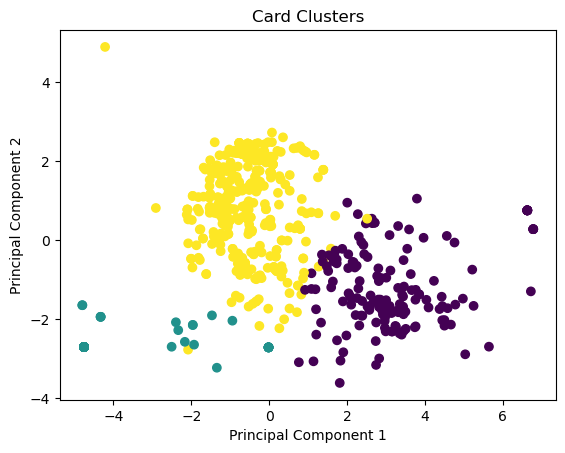

In [15]:
plt.scatter(data_2d[:, 0], data_2d[:, 1], c=df_to_cluster['cluster'], cmap='viridis')
plt.title('Card Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [16]:
sil = silhouette_score(data_scaled, df_to_cluster["cluster"])

In [17]:
sil

0.309029046496792

- Overall Not Bad at all for a second try, especially compared to the first
- We can start to see the makings of 2 clusters, and a barely a third.
- Silhouette Score is a metric for measuring the distance of point from neighboring clusters in combination with how close it is to points of its own cluster.
- in essesnce it measures cluster distance and density, with values closer to 1 meaning good distance and density, values closer to 0 meaning more amporphous shaped clusters (like ours), and values closer to -1 meaning far away from your own cluster and close to your neighbors
- here we scored a .3 closer to 0 than 1, but still positive. There's a lot more we can get out of this data! For now let's make some aggregate cards so SEI can start building the backend

## Aggregate Cards

- Here we:
    - calculate the centroids as the mean values of the clustered data
    - calculate the mean values of our grouping columns we created during cleaning above to signify the credit tiers the plans belonged too
    - in case the clusters are made up of cards from all three tiers, identify the correct tier per cluster/agg card by taking the max mean the three groupings and assigning that as the correct tier

In [19]:
cluster_centroids = df_to_cluster.groupby('cluster').mean()

In [30]:
# Calculate the mean values of the binary columns for each cluster
binary_columns = ['Poor_Fair_Group', 'Good_Credit_Group', 'Great_Credit_Group']
mean_binary_values = cluster_centroids[binary_columns]

In [31]:
# Determine the credit group associated with each cluster
credit_groups = []
for cluster_idx, row in mean_binary_values.iterrows():
    max_mean_value = row.max()
    associated_group = row[row == max_mean_value].index[0]
    credit_groups.append(associated_group)

In [32]:
# Add the determined credit group to the cluster_centroids DataFrame
cluster_centroids['Credit_Group'] = credit_groups

In [33]:
cluster_centroids

,PF_Credit_APR,Good_Credit_APR,Great_Credit_APR,Minimum APR,Median APR,Maximum APR,BT_Min_APR,BT_Max_APR,Median Length of Balance Transfer APR,CA_Min_APR,...,CA_Max_APR,Grace Period,Min_FinCharge_USD,BT_Fee_Percent,FgnTx_Fee_Percent,LF_6mo_BillCycle,Poor_Fair_Group,Good_Credit_Group,Great_Credit_Group,Credit_Group
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.160223,0.157005,0.128155,0.106529,0.111080,0.166091,0.073020,0.113705,2.502955e+02,0.119642,...,0.161999,24.305732,1.387197,0.013854,0.085758,13.187898,0.554140,0.923567,0.821656,Good_Credit_Group
1,0.297000,0.279500,0.000000,0.328594,0.332783,0.332518,0.000000,0.000000,0.000000e+00,0.332067,...,0.335296,26.849315,0.945205,0.000000,0.081644,37.835616,0.958904,0.068493,0.000000,Poor_Fair_Group
2,0.144556,0.240422,0.203437,0.186750,0.245017,0.252886,0.034339,0.045405,2.392352e+06,0.272691,...,0.287362,22.985646,1.057416,0.035048,0.017148,36.476077,0.488038,0.787081,0.954545,Great_Credit_Group


- here we reorder the columns so that the cluster and the credit groups are in the beginning columns for the other teams and better readability

In [37]:
cluster_centroids.columns

Index(['PF_Credit_APR', 'Good_Credit_APR', 'Great_Credit_APR', 'Minimum APR',
       'Median APR', 'Maximum APR', 'BT_Min_APR', 'BT_Max_APR',
       'Median Length of Balance Transfer APR', 'CA_Min_APR', 'CA_Median_APR',
       'CA_Max_APR', 'Grace Period', 'Min_FinCharge_USD', 'BT_Fee_Percent',
       'FgnTx_Fee_Percent', 'LF_6mo_BillCycle', 'Poor_Fair_Group',
       'Good_Credit_Group', 'Great_Credit_Group', 'Credit_Group'],
      dtype='object')

In [38]:
column_order = ['Credit_Group','PF_Credit_APR', 'Good_Credit_APR', 'Great_Credit_APR', 'Minimum APR',
       'Median APR', 'Maximum APR', 'BT_Min_APR', 'BT_Max_APR',
       'Median Length of Balance Transfer APR', 'CA_Min_APR', 'CA_Median_APR',
       'CA_Max_APR', 'Grace Period', 'Min_FinCharge_USD', 'BT_Fee_Percent',
       'FgnTx_Fee_Percent', 'LF_6mo_BillCycle', 'Poor_Fair_Group',
       'Good_Credit_Group', 'Great_Credit_Group']

In [40]:
cluster_centroids[column_order].to_csv('../data/aggregate_cards.csv')

In [42]:
col_order=['cluster','Availability of Credit Card Plan', 'Requirements for Opening',
       'Secured Card', 'Purchase APR Offered?', 'Purchase APR Vary by Balance',
       'Purchase APR Index', 'Variable Rate Index', 'Index', 'PF_Credit_APR',
       'Good_Credit_APR', 'Great_Credit_APR', 'Minimum APR', 'Median APR',
       'Maximum APR', 'Introductory APR Offered?', 'Balance Transfer Offered?',
       'Balance Transfer APR Vary by Credit Tier', 'BT_Min_APR', 'BT_Max_APR',
       'Median Length of Balance Transfer APR',
       'Balance Transfer Grace Period', 'Cash Advance APR Offered?',
       'Cash Advance APR Vary by Credit Tier', 'CA_Min_APR', 'CA_Median_APR',
       'CA_Max_APR', 'Grace Period Offered?', 'Grace Period',
       'Minimum Finance Charge?', 'Min_FinCharge_USD',
       'Balance Computation Method', 'Purchase Transaction Fees',
       'Balance Transfer Fees?', 'BT_Fee_Percent', 'Cash Advance Fees?',
       'Foreign Transaction Fees?', 'FgnTx_Fee_Percent', 'Late Fees?',
       'LF_6mo_BillCycle', 'Poor_Fair_Group', 'Good_Credit_Group',
       'Great_Credit_Group']

In [44]:
df_to_cluster[col_order].to_csv('../data/clustered_data.csv')

### One Hot Encoded Attempt

- Overall Much better than the results below! 
- Cleaning the Data more closely as well as removing outliers with respect to the "9.99" values has created much clearer groupings.
- There is still a weaker third grouping and this can probably be improved with the addition of other categorical values. let's try adding a view to see if it helps distinguish. if not or even if slightly better we will use these as the initial aggregate cards

In [43]:
df_to_cluster[obj_cols].head()

,Availability of Credit Card Plan,Requirements for Opening,Secured Card,Purchase APR Offered?,Purchase APR Vary by Balance,Purchase APR Index,Variable Rate Index,Index,Introductory APR Offered?,Balance Transfer Offered?,...,Cash Advance APR Offered?,Cash Advance APR Vary by Credit Tier,Grace Period Offered?,Minimum Finance Charge?,Balance Computation Method,Purchase Transaction Fees,Balance Transfer Fees?,Cash Advance Fees?,Foreign Transaction Fees?,Late Fees?
0,National,No,No,Yes,No,No,__,F,No,Yes,...,Yes,No,Yes,No,Average daily balance including new purchases,No,Yes,Yes,Yes,Yes
1,National,No,No,Yes,No,No,__,F,No,Yes,...,Yes,No,Yes,Yes,Average daily balance including new purchases,No,No,No,No,No
2,National,Yes,No,Yes,No,Yes,Prime,V,No,Yes,...,Yes,No,Yes,Yes,Average daily balance excluding new purchases,No,Yes,Yes,No,Yes
3,Regional,Yes,No,No,__,__,__,F,No,Yes,...,Yes,No,Yes,No,Average daily balance including new purchases,No,No,No,Yes,Yes
4,National,No,No,Yes,No,No,__,F,No,Yes,...,Yes,Yes,Yes,No,Average daily balance including new purchases,No,No,No,Yes,Yes


In [44]:
cols_to_encode = ['Availability of Credit Card Plan','Requirements for Opening','Index',
                  'Grace Period Offered?','Minimum Finance Charge?','Purchase Transaction Fees',
                  'Balance Transfer Fees?','Cash Advance Fees?','Foreign Transaction Fees?','Late Fees?']

OHE Pipeline

In [46]:
# Create a ColumnTransformer
column_transformer = make_column_transformer(
    (OneHotEncoder(), cols_to_encode),
    remainder='passthrough',
)

In [47]:
ohe_transformed = column_transformer.fit_transform(df_to_cluster[cols_to_encode])

In [49]:
encoded_column_names = column_transformer.named_transformers_['onehotencoder'].get_feature_names_out(cols_to_encode)

In [50]:
df_transformed = pd.DataFrame(data=ohe_transformed,columns=encoded_column_names)

In [51]:
df_transformed.head()

,Availability of Credit Card Plan_National,Availability of Credit Card Plan_One State/Territory,Availability of Credit Card Plan_Regional,Requirements for Opening_No,Requirements for Opening_Yes,Index_F,Index_V,Grace Period Offered?_No,Grace Period Offered?_Yes,Minimum Finance Charge?_No,Minimum Finance Charge?_Yes,Purchase Transaction Fees_No,Balance Transfer Fees?_No,Balance Transfer Fees?_Yes,Cash Advance Fees?_No,Cash Advance Fees?_Yes,Foreign Transaction Fees?_No,Foreign Transaction Fees?_Yes,Late Fees?_No,Late Fees?_Yes
0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


As you can see we now have columns that represent all options for the categorical fields we selected.
- now we combine numerical and ohe
- scale our data
- try clustering again!

In [52]:
transformed_df_clustering = pd.concat([df1_num_tf,df_transformed], axis=1)

In [54]:
sc = StandardScaler()

In [55]:
data_scaled = sc.fit_transform(transformed_df_clustering)

In [56]:
kmeans2 = KMeans(n_clusters=3, random_state=42)

In [62]:
df_to_cluster["cluster"] = kmeans2.fit_predict(data_scaled)

/Users/christopherjoyce/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [63]:
pca = PCA(n_components=2)

In [64]:
data_2d = pca.fit_transform(data_scaled)

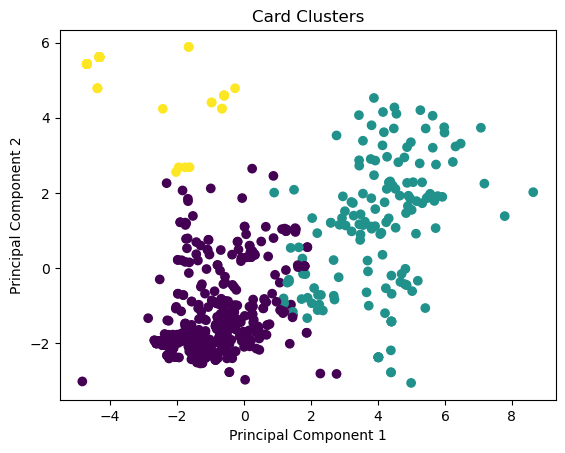

In [66]:
plt.scatter(data_2d[:, 0], data_2d[:, 1], c=df_to_cluster['cluster'], cmap='viridis')
plt.title('Card Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [67]:
sil = silhouette_score(data_scaled, df_to_cluster["cluster"])

In [68]:
sil

0.2607873585800693

### Original Clustering Attempt on new data set
---

In [128]:
df1 = df.copy()

In [151]:
df1_num = df[num_cols]

In [152]:
from sklearn.impute import KNNImputer

In [153]:
knn = KNNImputer(missing_values=np.nan, n_neighbors=5,metric='nan_euclidean')

In [154]:
data = knn.fit_transform(df1_num)

In [155]:
df1_num_tf = pd.DataFrame(data=data,columns=knn.get_feature_names_out())

In [156]:
df1_num_tf.head()

,Poor or Fair Credit,Good Credit,Great Credit,Minimum APR,Median APR,Maximum APR,Minimum APR.2,Maximum APR.2,Median Length of Balance Transfer APR,Minimum APR.3,...,Maximum APR.3,Grace Period,Minimum Finance Charge (Dollars),Balance Transfer Fee (%),Amount (Percent) - Transaction Fee,Foreign Transaction Fee (%),Amount (Dollars) - Late Payment Fee,Late Fee Six Month Billing Cycle,Other Fee Amount,Other Fee Amount.1
0,2.16780,0.19928,0.15578,0.14900,0.14900,0.18000,0.1490,0.1800,0.0,0.1490,...,0.1800,25.0,1.100,0.030,0.020,0.010,10.0,33.8,26.2,23.42
1,2.13680,0.14278,0.11426,0.11500,0.11500,0.11500,0.1150,0.1150,6.0,0.1150,...,0.1150,25.0,0.010,0.024,0.024,0.014,26.2,33.0,22.8,18.60
2,4.11096,0.19692,0.18062,0.20990,0.20990,0.20990,0.2099,0.2099,6.0,0.2499,...,0.2499,6.0,0.500,0.030,0.030,0.027,29.0,40.0,29.4,17.00
3,0.21430,0.20430,0.17532,0.15466,0.15844,0.18586,0.1650,0.1650,16.5,0.1650,...,0.1650,25.0,3.880,0.038,0.030,0.010,26.2,33.6,27.0,20.60
4,0.15900,0.10900,0.07900,0.07900,0.13540,0.16900,0.0790,0.1690,6.0,0.0790,...,0.1690,25.0,1.102,0.030,0.030,0.010,26.6,39.0,10.0,27.60


Clustering Alpha

In [145]:
# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
#clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

In [157]:
sc = StandardScaler()

In [158]:
data_scaled = sc.fit_transform(df1_num_tf)

In [159]:
kmeans = KMeans(n_clusters=3, random_state=42)

In [160]:
df1_num_tf["cluster"] = kmeans.fit_predict(data_scaled)

/Users/christopherjoyce/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [161]:
pca = PCA(n_components=2)

In [162]:
data_2d = pca.fit_transform(data_scaled)

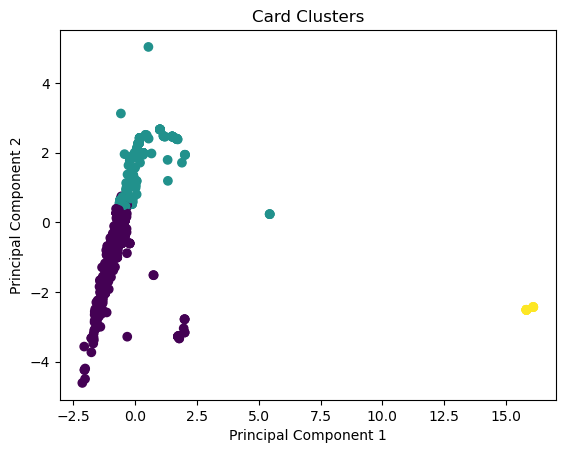

In [166]:
plt.scatter(data_2d[:, 0], data_2d[:, 1], c=df1_num_tf['cluster'], cmap='viridis')
plt.title('Card Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [164]:
sil = silhouette_score(data_scaled, df1_num_tf["cluster"])

In [165]:
sil

0.1929077438312663